In [54]:
# Import the necessary libraries
import pandas as pd 
import numpy as np 
import sys
import os
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import to_hex

from sklearn.metrics import mean_squared_error, mean_absolute_error


from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import cross_val_score
import time
#import warnings
import warnings
warnings.filterwarnings("ignore")

## Load and Prepare the Dataset

In [55]:
df_all = pd.read_csv("D:\\OneDrive - HvA\\LTP company\\Forecasting\\Dataset official\\df_top_10_products.csv")

# Drop irrelevant columns
df_all.drop(columns=['Unit price', 'Discount', 'Product group'], inplace=True)

# Type conversion
df_all['ProductCode'] = df_all['ProductCode'].astype('category')
df_all['Order date'] = pd.to_datetime(df_all['Order date'])

# Group to weekly sales
weekly_sales_all = df_all.groupby(['ProductCode', pd.Grouper(key='Order date', freq='W-MON')])['Quantity'] \
                        .sum().reset_index()
weekly_sales_all.rename(columns={'Order date': 'WeekStart', 'Quantity': 'WeeklySales'}, inplace=True)


## Feature engineering

In [56]:
#change the product code to categorical
weekly_sales_all['ProductCode'] = weekly_sales_all['ProductCode'].astype('category')


In [57]:
#the number of rows in weekly_sales_all
print(f"Number of rows in weekly_sales_all: {len(weekly_sales_all)}")

Number of rows in weekly_sales_all: 1230


In [58]:
#check the number of rows has zero values in weekly sales
zero_sales = weekly_sales_all["WeeklySales"]==0
print(f"Number of rows with zero weekly sales: {zero_sales.sum()}")

Number of rows with zero weekly sales: 216


In [59]:
#drop the rows with zero weekly sales
weekly_sales_all = weekly_sales_all[weekly_sales_all['WeeklySales'] > 0]
#check the number of rows after dropping the zero weekly sales
print(f"Number of rows after dropping zero weekly sales: {len(weekly_sales_all)}")

Number of rows after dropping zero weekly sales: 1014


In [60]:
#create the date features
weekly_sales_all['Year'] = weekly_sales_all['WeekStart'].dt.year
weekly_sales_all['Month'] = weekly_sales_all['WeekStart'].dt.month
weekly_sales_all['Week_of_year'] = weekly_sales_all['WeekStart'].dt.isocalendar().week
weekly_sales_all['Week_of_month'] = (weekly_sales_all['WeekStart'].dt.day - 1) // 7 + 1


In [61]:
#create a lag feature
def add_lag_features(df, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby('ProductCode')['WeeklySales'].shift(lag)
    return df

lags = [1, 2, 3, 4, 13, 26, 52]
weekly_sales_all = add_lag_features(weekly_sales_all, lags)

In [62]:
#create a difference feature
def add_diff_features(df, diffs):
    for diff in diffs:
        df[f'diff_{diff}'] = df.groupby('ProductCode')['WeeklySales'].diff(diff)
    return df

diffs = [1, 2, 3, 4, 13, 26, 52]
weekly_sales_all = add_diff_features(weekly_sales_all, diffs)


In [63]:
#the number of unique weekStart
unique_weeks = weekly_sales_all['WeekStart'].nunique()
print(f"Number of unique weeks in the dataset: {unique_weeks}")

Number of unique weeks in the dataset: 122


In [64]:
# Function to split the data into train, validation, and test sets
def split_data(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    train_list, val_list, test_list = [], [], []

    for product, group in df.groupby("ProductCode"):
        group = group.sort_values("WeekStart")
        total_weeks = len(group)
        
        # Minimum weeks check
        if total_weeks < 30:
            continue

        n_train = int(total_weeks * train_ratio)
        n_val = int(total_weeks * val_ratio)
        n_test = total_weeks - n_train - n_val  # balance remainder

        train = group.iloc[:n_train]
        val = group.iloc[n_train:n_train + n_val]
        test = group.iloc[n_train + n_val:]

        train_list.append(train)
        val_list.append(val)
        test_list.append(test)

    return pd.concat(train_list), pd.concat(val_list), pd.concat(test_list)



In [65]:
train_data, val_data, test_data = split_data(weekly_sales_all)

In [66]:
#print the length of each dataset
print(f"Length of training data: {len(train_data)}")
print(f"Length of validation data: {len(val_data)}")
print(f"Length of test data: {len(test_data)}")

Length of training data: 705
Length of validation data: 147
Length of test data: 162


In [67]:
#identify the features and target variable
list_columns = weekly_sales_all.columns.tolist()
features_all = [col for col in list_columns if col not in ['WeekStart', 'WeeklySales']]
print(f"Features used for modeling: {features_all}")

Features used for modeling: ['ProductCode', 'Year', 'Month', 'Week_of_year', 'Week_of_month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_13', 'lag_26', 'lag_52', 'diff_1', 'diff_2', 'diff_3', 'diff_4', 'diff_13', 'diff_26', 'diff_52']


In [68]:
#target variable
target_all = 'WeeklySales'

In [69]:
#identify  x and y for train, validation, and test sets
X_train_all = train_data[features_all]
y_train_all = train_data[target_all]

X_val_all = val_data[features_all]
y_val_all = val_data[target_all]

X_test_all = test_data[features_all]
y_test_all = test_data[target_all]


In [70]:
# Ensure categorical
for df in [X_train_all, X_val_all, X_test_all]:
    df['ProductCode'] = df['ProductCode'].astype('category')

In [71]:
cat_feature_index = [X_train_all.columns.get_loc('ProductCode')]

In [72]:
# Model
model = LGBMRegressor()

In [73]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error
import time

# Define parameter grid to search
param_grid2 = {
    'learning_rate': [0.03, 0.05],
    'max_depth': [4, 5],
    'num_leaves': [20, 25],
    'min_data_in_leaf': [30, 40],
    'reg_alpha': [0.3, 0.5],
    'reg_lambda': [0.3, 0.5],
    'n_estimators': [300, 500]
}

# Base model
base_model = LGBMRegressor()

# Fit parameters using the validation set
fit_params2 = {
    "eval_set": [(X_val_all, y_val_all)],
    "eval_metric": "mse",
    "categorical_feature": cat_feature_index,
    "callbacks": [early_stopping(30), log_evaluation(10)]
}

# GridSearchCV setup
grid2 = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid2,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Train the model and track time
start2 = time.time()
grid2.fit(X_train_all, y_train_all, **fit_params2)
train_time2 = time.time() - start2

# Best model prediction on test set
best_model = grid2.best_estimator_
y_test_pred = best_model.predict(X_test_all)

# Evaluate
mse = mean_squared_error(y_test_all, y_test_pred)
rmse = np.sqrt(mse)

print(f"Best Params: {grid2.best_params_}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Train time: {train_time2:.2f} seconds")


Fitting 3 folds for each of 128 candidates, totalling 384 fits


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2627
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 19
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Start training from score 142.851064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [74]:
# Predict
start = time.time()
y_train_pred = best_model.predict(X_train_all)
y_val_pred = best_model.predict(X_val_all)
y_test_pred = best_model.predict(X_test_all)
predict_time = time.time() - start

# Evaluate
train_rmse = np.sqrt(mean_squared_error(y_train_all, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_all, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_all, y_test_pred))

train_mae = mean_absolute_error(y_train_all, y_train_pred)
val_mae = mean_absolute_error(y_val_all, y_val_pred)
test_mae = mean_absolute_error(y_test_all, y_test_pred)

# Report
print(f"Train RMSE: {train_rmse:.2f} | MAE: {train_mae:.2f}")
print(f"Validation RMSE: {val_rmse:.2f} | MAE: {val_mae:.2f}")
print(f"Test RMSE: {test_rmse:.2f} | MAE: {test_mae:.2f}")
print(f"Prediction time: {predict_time:.2f} seconds")


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Train RMSE: 21.55 | MAE: 9.67
Validation RMSE: 50.61 | MAE: 24.00
Test RMSE: 53.38 | MAE: 21.15
Prediction time: 0.07 seconds


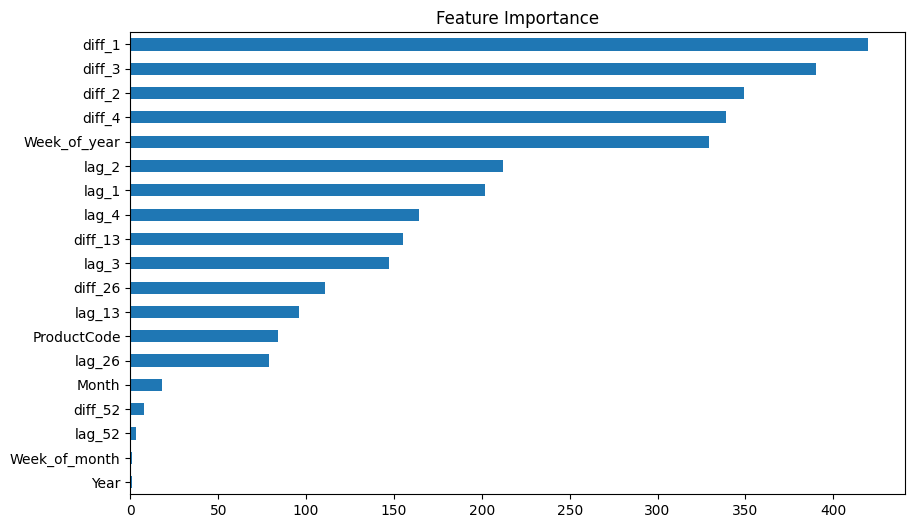

In [75]:
import matplotlib.pyplot as plt

lgb_importances = pd.Series(best_model.feature_importances_, index=X_train_all.columns)
lgb_importances.sort_values().plot(kind='barh', figsize=(10, 6), title="Feature Importance")
plt.show()